<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Contrôle-de-la-qualité-des-datasets" data-toc-modified-id="Contrôle-de-la-qualité-des-datasets-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Contrôle de la qualité des datasets</a></span></li><li><span><a href="#Sélection-des-features" data-toc-modified-id="Sélection-des-features-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Sélection des features</a></span><ul class="toc-item"><li><span><a href="#A-l'aide-d'un-LassoCV" data-toc-modified-id="A-l'aide-d'un-LassoCV-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>A l'aide d'un LassoCV</a></span><ul class="toc-item"><li><span><a href="#Quésako-?" data-toc-modified-id="Quésako-?-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Quésako ?</a></span></li><li><span><a href="#Les-principales-features" data-toc-modified-id="Les-principales-features-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>Les principales features</a></span></li><li><span><a href="#Les-features-d'importance" data-toc-modified-id="Les-features-d'importance-2.1.3"><span class="toc-item-num">2.1.3&nbsp;&nbsp;</span>Les features d'importance</a></span></li></ul></li><li><span><a href="#A-l'aide-d'un-RandomForestRegressor-naif" data-toc-modified-id="A-l'aide-d'un-RandomForestRegressor-naif-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>A l'aide d'un RandomForestRegressor naif</a></span></li></ul></li><li><span><a href="#Développement-de-la-Pipeline-avec-XGBoost-et-LGBoosting" data-toc-modified-id="Développement-de-la-Pipeline-avec-XGBoost-et-LGBoosting-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Développement de la Pipeline avec XGBoost et LGBoosting</a></span><ul class="toc-item"><li><span><a href="#Feature-selection-RandomForest" data-toc-modified-id="Feature-selection-RandomForest-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Feature selection RandomForest</a></span></li><li><span><a href="#Feature-selection-Lasso" data-toc-modified-id="Feature-selection-Lasso-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Feature selection Lasso</a></span></li><li><span><a href="#Sans-feature-selection" data-toc-modified-id="Sans-feature-selection-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Sans feature selection</a></span></li></ul></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.linear_model import LassoCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

import xgboost as xgb
from lightgbm import LGBMRegressor

import math

In [2]:
train= pd.read_csv("../good_data/donnees_model/donnees_train.csv")
test= pd.read_csv("../good_data/donnees_model/donnees_test.csv")
valid= pd.read_csv("../good_data/donnees_model/donnees_validation.csv")

In [3]:
# System variable / for model training
n_jobs= 10
verbose= 1

## Contrôle de la qualité des datasets

In [4]:
def dim_df(df):
    return df.shape[0], df.shape[1]

# Check we have the same number of col
assert dim_df(train)[1] == dim_df(test)[1] == dim_df(valid)[1]

In [5]:
# To iterate dataset into for bound
stock_dico= {"train": train, "test": test, "valid": valid}
listed_index= [i for i in stock_dico.keys()]
# Some column are useless 
useless_col= ["Unnamed: 0", "idmutation", "FR", "Ind", "irl", "geometry", "year"
             , "valeurfo_1", "valeurfo_2", "valeurfo_3", "rate_cumpr", "IdINSPIRE", "datemut"
             , "l_codinsee", "libtypbien", "valfoncact", "sbati_squa"]

not_object_col= [i for i in train.columns if train[i].dtypes != "object" and i not in useless_col]
print("On a {} colonne à analyser".format(len(not_object_col)))

diff_df= pd.DataFrame()
for i in not_object_col:
    tr= train[i]
    tt= test[i]
    vl= valid[i]
    
    diff_mean_dico= pd.DataFrame({"col": i, "Train": [tr.mean()]
                                  , "Test": [tt.mean()], "Valid":[vl.mean()]
                                  })
    diff_df= pd.concat([diff_df, diff_mean_dico])
    
pd.set_option('display.max_rows', None)
diff_df.set_index("col")

On a 64 colonne à analyser


,Train,Test,Valid
col,,,
valeurfonc,4.939049e+05,4.984056e+05,4.869398e+05
nblot,1.899142e+00,1.895551e+00,1.891080e+00
nbpar,1.009435e+00,1.009370e+00,1.010445e+00
nblocmut,1.192953e+00,1.193393e+00,1.191668e+00
nblocdep,1.929526e-01,1.933932e-01,1.916682e-01
sbati,5.436308e+01,5.468331e+01,5.373132e+01
pp,2.380353e+00,2.385351e+00,2.358725e+00
Men,1.774630e+05,1.777653e+05,1.777340e+05
Men_pauv,2.468828e+00,2.540819e+00,2.486712e+00


On remarque que dans chacun de nos datasets, les moyennes semblent similaires (pas de ttest car c'est juste une étape de contrôle sachant que le split a été fait de manière aléatoire)

## Sélection des features

Avec l'enrichissement du dataset, on se retrouve avec plus de 70 variables pour modéliser la valeur foncière : c'est beaucoup. Alors pour éviter les problèmes d'overfitting et le temps de calcul excessif on va chercher à extraire les features les plus importantes de notre dataset.

### A l'aide d'un LassoCV

#### Quésako ?

C'est simplement le meilleur modèle linéaire Lasso que l'on sélectionne à l'aide d'une cross-validation. Les cross-validation estimator sont des modèles qui sélectionnent les meilleurs hyper-paramètres. C'est comme si on avait performe une grid-search. Ici, on l'utilise dansle but de pas trop se casser la tête à chercher un bon modèle pour simplement sélectionner des features.

#### Les principales features

In [6]:
train_good_data= train[train.columns[~train.columns.isin(useless_col)]].copy()
train_label= train_good_data.pop("valeurfonc")
train_good_col= [i for i in train_good_data.columns]

# Scale nos variables pour la feature select
scaler_std= StandardScaler()
train_good_data[train_good_col]= scaler_std.fit_transform(train_good_data[train_good_col])

# Feature selection à l'aide d'un LASSO
lasso= LassoCV()
lasso.fit(train_good_data, train_label)
sf_lasso= SelectFromModel(lasso, prefit= True)

In [7]:
selected_feat_lasso= train_good_data.columns[(sf_lasso.get_support())]
print(len(selected_feat_lasso))
print(selected_feat_lasso)

44
Index(['nblot', 'nbpar', 'nblocmut', 'sbati', 'pp', 'Men', 'Men_5ind',
       'Men_prop', 'Men_fmp', 'Ind_snv', 'Log_av45', 'Log_45_70', 'Log_70_90',
       'Log_inc', 'Log_soc', 'Ind_0_3', 'Ind_4_5', 'Ind_6_10', 'Ind_25_39',
       'Ind_40_54', 'Ind_55_64', 'Ind_65_79', 'Ind_inc', 'ind_par_zo',
       'nv_par_hab', 'ind_par__1', 'MEDECIN GE', 'MATERNELLE', 'HYPERMARCH',
       'GARAGE', 'BANQUE', 'RESTAURANT', 'EPICERIE', 'SUPERMARCH', 'PHARMACIE',
       'POISONNERI', 'BOUCHERIE', 'SUPERETTE', 'POLICE', 'POSTE', 'MUSEE',
       'CRECHE', 'THEATRE', 'arrondissement'],
      dtype='object')


#### Les features d'importance

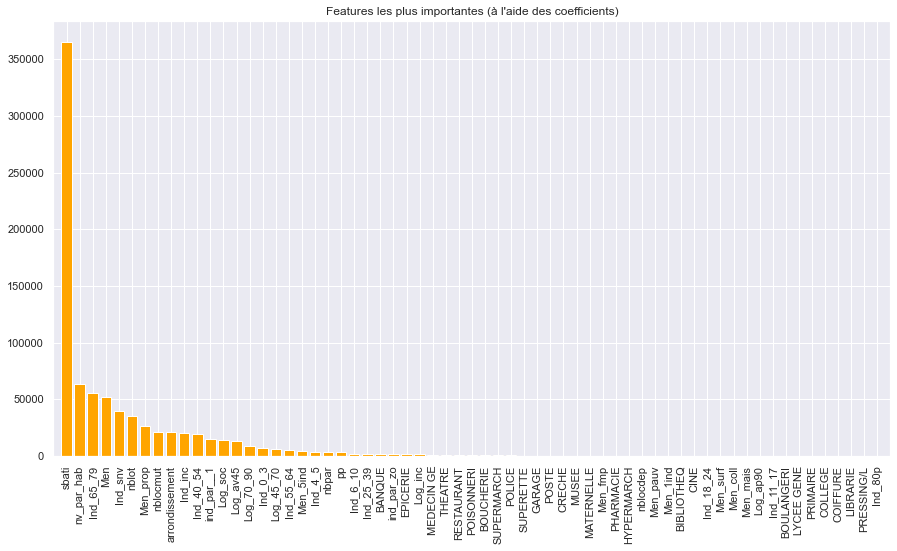

In [8]:
importance_feature= np.abs(lasso.coef_)
indices= np.argsort(importance_feature)[::-1]
lasso_importance_col= train_good_data.iloc[:, indices.tolist()].columns

plt.figure(figsize= (15, 8))

plt.bar(range(train_good_data.shape[1]), importance_feature[indices],
        color= "orange", align= "center")

plt.xticks(range(train_good_data.shape[1]),  lasso_importance_col, rotation= "vertical")
plt.xlim([-1, train_good_data.shape[1]])
plt.title("Features les plus importantes (à l'aide des coefficients)")
plt.show()

Pour chercher à comprendre l'importance des variables à l'aide d'un LassoCV, Sklearn propose d'observer [la valeur des coefficients de la régression](https://scikit-learn.org/dev/auto_examples/feature_selection/plot_select_from_model_diabetes.html). C'est une vue rapide et simple de comment notre modèle considère les variables.

Ici, la variable qui semble la plus importante est **la surface habitable** du bien. Ensuite **le niveau de vie moyen par habitant du carreau** dans lequel se situe le bien immobilier. Aussi, la densité semble importante avec la variable **Men** qui représente le nombre de ménage au sein du carreau. Aussi, la part de personne agés de 65 à 79 ans est aussi une information importante.

Globablement, les variables qui ressortent sont cohérentes avec ce qu'on pourrait penser naturellement pour qualifier la valeur d'un bien surtout à Paris, comme la surface, les niveaux de vie etc.

### A l'aide d'un RandomForestRegressor naif

In [9]:
# Feature selection à l'aide d'un RandomForest
rf= RandomForestRegressor(verbose= verbose, n_jobs= n_jobs).fit(train_good_data, train_label)
sf_rf= SelectFromModel(rf, prefit= True)

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  1.1min
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:  3.5min finished


In [10]:
selected_feat_rf= train_good_data.columns[(sf_rf.get_support())]
print(len(selected_feat_rf))
print(selected_feat_rf)

6
Index(['nblot', 'sbati', 'Ind_65_79', 'Ind_80p', 'nv_par_hab',
       'arrondissement'],
      dtype='object')


In [11]:
importance_feature= rf.feature_importances_
std= np.std([i.feature_importances_ for i in rf.estimators_], axis=0)
indices= np.argsort(importance_feature)[::-1]

rf_importance_col= train_good_data.iloc[:, indices.tolist()].columns

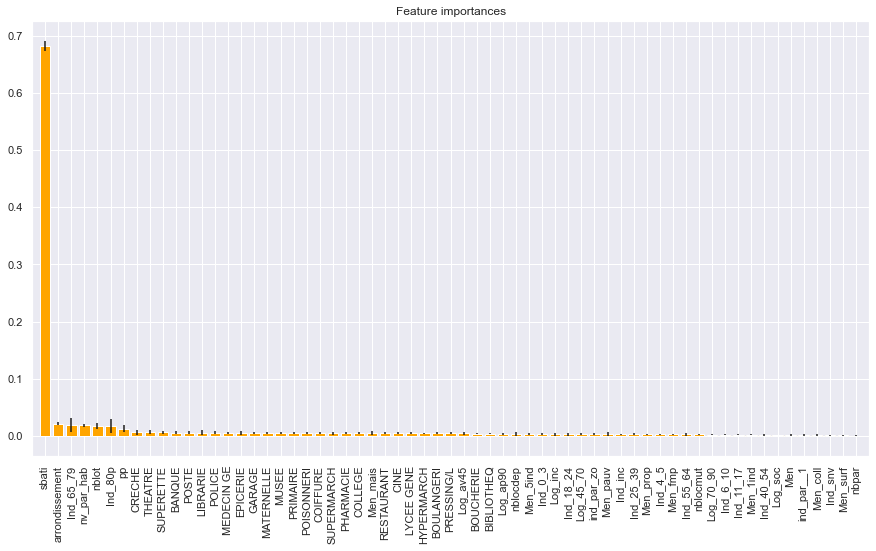

In [12]:
plt.figure(figsize= (15, 8))

plt.title("Feature importances")
plt.bar(range(train_good_data.shape[1]), importance_feature[indices],
        color= "orange", yerr= std[indices], align= "center")
plt.xticks(range(train_good_data.shape[1]),  rf_importance_col, rotation= "vertical")
plt.xlim([-1, train_good_data.shape[1]])
plt.show()

Avec l'utilisation d'un random forest naif, c'est à dire train à la volée, on se rend compte qu'il n'y a que 5 features qui sont sélectionnées (similaires avec les features importantes du Lasso). De plus, lorsqu'on regarde les features d'importances du modèles trained, on remarque 2 choses :
- la variable surface d'habitation est la plus importante et de loin
- la écart-type (représentée par le trait noir vertical) est faible pour toute les features. En faite, comme on a 100 arbres qui sont construits, on peut calculer l'écart-type pour chaque variable.

## Développement de la Pipeline avec XGBoost et LGBoosting

In [35]:
def random_search_pipeline(pipeline, params, scoring, cv, n_iter, train_x, train_y):
    """
    """
    random_search= RandomizedSearchCV(pipeline, param_distributions=params, scoring= scoring
                                      , n_iter=n_iter, verbose= verbose, cv= cv, n_jobs= n_jobs
                                      , random_state= 55)

    random_search.fit(train_x, train_y)
    return random_search


def rmse(model, test, label):
    prediction= model.predict(test)
    print("RMSE: %.2f"
          % math.sqrt(np.mean((prediction - label) ** 2)))
    pass

def rmse_adjusted(model, test, label, thresh= 400000):
    prediction= model.predict(test)
    diff= prediction - label
    ndiff= np.where(np.abs(diff) < thresh, diff, np.nan)
    print("Pourcentage de prédiction avec un erreur supérieur à {}: {}"\
          .format(thresh, sum(np.isnan(ndiff))/ndiff.shape[0]))
    new_diff= ndiff[~np.isnan(ndiff)]
    print("RMSE ADJUSTED: %.2f"
          % math.sqrt(np.mean((new_diff) ** 2)))
    pass

def mae(model, test, label):
    prediction= model.predict(test)
    print("MAE: %.2f"
          % np.mean(np.abs(prediction - label)))
    pass

### Feature selection RandomForest

In [42]:
# Construction de nos dataset
train_good_data= train[train.columns[~train.columns.isin(useless_col)]].copy()
train_label= train_good_data.pop("valeurfonc")

train_rf= train_good_data.loc[:, selected_feat_rf.tolist()]

test_copy= test.copy()
test_label= test_copy.pop("valeurfonc")
test_rf= test_copy.loc[:, selected_feat_rf.tolist()]

In [43]:
xgb_regressor= xgb.XGBRegressor(eval_metric= "rmse", tree_method= "gpu_hist", predictor= "gpu_predictor")

pipeline_xgb= Pipeline([
    ('standard_scaler', StandardScaler()),
    ('model', xgb_regressor)
])

parameters_for_testing = {
   'model__min_child_weight':[1.5, 6, 10],
   'model__learning_rate':[0.1, 0.07, 0.15, 0.05, 0.02],
   'model__max_depth':[1, 2, 3, 4, 5],
   'model__reg_alpha':[0.05, 0.01],
   'model__reg_lambda':[0.01, 0.05, 0.1],
   'model__colsample_bytree':[0.2, 0.4, 0.5]
}

lgb_model = LGBMRegressor(objective= "root_mean_squared_error", boosting_type= "gbdt")

pipeline_lgb= Pipeline([
    ('standard_scaler', StandardScaler()),
    ('model', lgb_model)
])

parameters_for_testing_lgb = {
    'model__learning_rate': [0.02, 0.05, 0.08, 0.1, 0.2],
    'model__n_estimators': [500, 700, 1000],
    'model__num_leaves': [30, 40, 50],
    'model__colsample_bytree' : [0.5, 0.8],
    'model__subsample' : [0.5, 0.4, 0.2],
    'model__reg_alpha' : [0, 0.02],
    'model__reg_lambda' : [0, 0.1],
    'model__max_depth': [4, 5]
    }

# print("XGB avec feature selection de RandomForest\n")
# random_search_xgb= random_search_pipeline(pipeline_xgb, parameters_for_testing
#                                           , "neg_root_mean_squared_error", 3, 100, train_rf, train_label)

# rmse(random_search_xgb, test_rf, test_label)
# mae(random_search_xgb, test_rf, test_label)


print("LGB avec feature selection de RandomForest\n")
random_search_lgb= random_search_pipeline(pipeline_lgb, parameters_for_testing_lgb
                                          , "neg_root_mean_squared_error", 3, 100, train_rf, train_label)

rmse(random_search_lgb, test_rf, test_label)
rmse_adjusted(random_search_lgb, test_rf, test_label)
mae(random_search_lgb, test_rf, test_label)

LGB avec feature selection de RandomForest

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   42.4s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:  3.4min
[Parallel(n_jobs=10)]: Done 300 out of 300 | elapsed:  5.8min finished


RMSE: 275539.60
Pourcentage de prédiction avec un erreur supérieur à 400000: 0.04828498269506739
RMSE ADJUSTED: 107367.79
MAE: 110846.40


In [44]:
# from catboost import CatBoostRegressor

# model = CatBoostRegressor(iterations=2000, learning_rate= 0.10)
# model.fit(train_rf, train_label)

### Feature selection Lasso

In [45]:
# constrution de nos dataset
train_good_data= train[train.columns[~train.columns.isin(useless_col)]].copy()
train_label= train_good_data.pop("valeurfonc")
train_rf= train_good_data.loc[:, selected_feat_lasso.tolist()]

test_copy= test.copy()
test_label= test_copy.pop("valeurfonc")
test_rf= test_copy.loc[:, selected_feat_lasso.tolist()]

In [46]:
print("LGB avec feature selection de Lasso\n")
random_search_lgb= random_search_pipeline(pipeline_lgb, parameters_for_testing_lgb
                                          , "neg_root_mean_squared_error", 3, 100, train_rf, train_label)
rmse(random_search_lgb, test_rf, test_label)
rmse_adjusted(random_search_lgb, test_rf, test_label)
mae(random_search_lgb, test_rf, test_label)

LGB avec feature selection de Lasso

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  1.7min
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:  8.8min
[Parallel(n_jobs=10)]: Done 300 out of 300 | elapsed: 15.0min finished


RMSE: 264597.83
Pourcentage de prédiction avec un erreur supérieur à 400000: 0.04614648695798981
RMSE ADJUSTED: 106306.11
MAE: 107987.36


In [47]:
# model = CatBoostRegressor(iterations=2000, learning_rate= 0.10)
# model.fit(train_rf, train_label)

In [48]:
# rmse(random_search_lgb, test_rf, test_label)
# rmse_adjusted(random_search_lgb, test_rf, test_label)
# mae(random_search_lgb, test_rf, test_label)

### Sans feature selection

In [49]:
train_good_data= train[train.columns[~train.columns.isin(useless_col)]].copy()
train_label= train_good_data.pop("valeurfonc")
train_rf= train_good_data

test_copy= test[test.columns[~test.columns.isin(useless_col)]].copy()
test_label= test_copy.pop("valeurfonc")
test_rf= test_copy

In [50]:
print("LGB sans feature selection\n")
random_search_lgb= random_search_pipeline(pipeline_lgb, parameters_for_testing_lgb
                                          , "neg_root_mean_squared_error", 3, 100, train_rf, train_label)

rmse(random_search_lgb, test_rf, test_label)
rmse_adjusted(random_search_lgb, test_rf, test_label)
mae(random_search_lgb, test_rf, test_label)

LGB sans feature selection

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:  2.1min
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed: 10.9min
[Parallel(n_jobs=10)]: Done 300 out of 300 | elapsed: 18.9min finished


RMSE: 262022.14
Pourcentage de prédiction avec un erreur supérieur à 400000: 0.046174625059793466
RMSE ADJUSTED: 105981.33
MAE: 107591.23
